In [1]:
import logging
import os
import pandas as pd
import numpy as np
import json

from pathlib import Path
from copy import deepcopy

%load_ext autoreload
%autoreload 2

# Disable logging of the program in the notebook
os.environ["LOGLEVEL"] = "CRITICAL"

logging.basicConfig()
logging.root.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('__main__')
logger.setLevel(os.environ.get("LOGLEVEL", logging.FATAL))

pybooklogger = logging.getLogger('pybook')
pybooklogger.setLevel(logging.DEBUG)

%aimport setup

from setup import *

# Track Layout
Calculate the layout of the dutch railway system


In [2]:
layout_file =   "../data/prorail/parsed/netherlands-schiphol.json"
layout = Layout(layout_file)

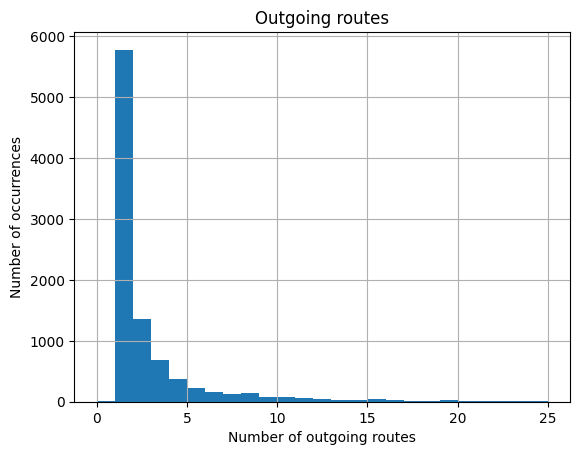

In [3]:
edges_df = pd.DataFrame({"Outgoing routes": [len(n.outgoing) for n in layout.g_block.nodes.values() if len(n.outgoing) <= 25]})
hist = edges_df.hist(bins=25, )
plt.xlabel("Number of outgoing routes")
plt.ylabel("Number of occurrences")
plt.show()

# Experiment Runtime Agents


In [4]:
scenario_file = "../data/prorail/scenarios/RT/2025-07-04_1.json"
agents = []
try:
    base_path = Path(__file__).parent
    file_path = (base_path / scenario_file).resolve()
    data = json.load(open(file_path))
except:
    data = json.load(open(scenario_file))

types = {x["name"]: x for x in data["types"]}
for trainNumber, entry in enumerate(data["trains"]):
    trainNumber += 1
    move = entry["movements"][0]
    velocity = types[entry["trainUnitTypes"][0]]["speed"] / 3.6

    agent = Agent(trainNumber, move["startLocation"], move["endLocation"], velocity, move["startTime"],
                  endTime=move["endTime"],
                  startTimeHuman=str(timedelta(seconds=move["startTime"])),
                  endTimeHuman=str(timedelta(seconds=move["endTime"])),
                  trainNumber=entry["trainNumber"],
                  trainUnitTypes=entry["trainUnitTypes"],
                  stops=move["stops"],
    )
    agents.append(agent)
agent_df = pd.DataFrame([agent.__dict__ for agent in agents])
series_3500o = agent_df.loc[(agent_df['trainNumber'].str.startswith("35", na=False)) & (agent_df['trainNumber'].astype(int) % 2 == 1)].sort_values("start_time")
agent_df

,id,origin,destination,velocity,start_time,endTime,startTimeHuman,endTimeHuman,trainNumber,trainUnitTypes,stops
0,1,RSD|4a,VS|3,38.888889,1320.0,5160.0,0:22:00,1:26:00,2222,[VIRM],"[{'expected_arrival': 1860.0, 'location': 'BGN..."
1,2,RTD|14,UT|12,38.888889,1260.0,3480.0,0:21:00,0:58:00,2037,[SLT],"[{'expected_arrival': 1740.0, 'location': 'RTA..."
2,3,HAD|1,ASD|2a,38.888889,240.0,1560.0,0:04:00,0:26:00,2124,[VIRM],"[{'expected_arrival': 540.0, 'location': 'HLM|..."
3,4,GVC|10,ASD|2a,38.888889,3720.0,6960.0,1:02:00,1:56:00,2130,[VIRM],"[{'expected_arrival': 4380.0, 'location': 'LED..."
4,5,UT|7,DDR|2,38.888889,1680.0,7680.0,0:28:00,2:08:00,3532,[VIRM],"[{'expected_arrival': 2640.0, 'location': 'ASB..."
...,...,...,...,...,...,...,...,...,...,...,...
106,107,GVC|3,DDR|3a,38.888889,4320.0,7500.0,1:12:00,2:05:00,5143,[SNG],"[{'expected_arrival': 4500.0, 'location': 'GV|..."
107,108,RSD|4a,VS|2,38.888889,3240.0,6720.0,0:54:00,1:52:00,6524,[SNG],"[{'expected_arrival': 3780.0, 'location': 'BGN..."
108,109,ASD|2a,GVC|10,38.888889,360.0,3540.0,0:06:00,0:59:00,2141,[VIRM],"[{'expected_arrival': 660.0, 'location': 'ASS|..."
109,110,GVC|11,LLS|3,38.888889,4920.0,11940.0,1:22:00,3:19:00,4343,[SLT],"[{'expected_arrival': 5100.0, 'location': 'LAA..."


In [5]:
longest = series_3500o.loc[series_3500o['stops'].map(len).idxmax()]

# This train would be at 2700 at GV|6, we will be replanning its path till ASDZ|2
longest

id                                                               61
origin                                                        DDR|2
destination                                                    VL|3
velocity                                                  38.888889
start_time                                                   1500.0
endTime                                                     13440.0
startTimeHuman                                              0:25:00
endTimeHuman                                                3:44:00
trainNumber                                                    3541
trainUnitTypes                                               [VIRM]
stops             [{'expected_arrival': 2160.0, 'location': 'RTB...
Name: 60, dtype: object

In [6]:
stops_df = pd.DataFrame(longest["stops"])
r_rtd = stops_df.loc[stops_df["location"].str.contains("RTD", na=False)]
r_asdz = stops_df.loc[stops_df["location"].str.contains("ASDZ", na=False)]

i_rtd = r_rtd.index[0] + 1
i_asdz = r_asdz.index[0]
stops = longest["stops"][i_rtd:i_asdz]

print(f"i_rtd={i_rtd}, i_asdz={i_asdz}")
print(f"stops={stops}")

move = {
    "endLocation": r_asdz["location"].iloc[0],
    "endTime": r_asdz["expected_arrival"].iloc[0],
    "startLocation": r_rtd["location"].iloc[0],
    "startTime": r_rtd["time"].iloc[0],
    "stops": stops,
}

block_path = layout.get_path_for_agent(move, longest["trainNumber"], longest["velocity"])

def filter_origin(n):
    return n.split("-")[1].split("|")[0]

allowed_nodes = {filter_origin(block_path[0].from_node.name)}
for e in block_path:
    allowed_nodes.add(filter_origin(e.to_node.name))
allowed_nodes

i_rtd=2, i_asdz=8
stops=[{'expected_arrival': 2760.0, 'location': 'SDM|5', 'time': 2760.0}, {'expected_arrival': 3180.0, 'location': 'DT|1', 'time': 3180.0}, {'expected_arrival': 3600.0, 'location': 'GV|6', 'time': 3720.0}, {'expected_arrival': 3900.0, 'location': 'LAA|6', 'time': 3900.0}, {'expected_arrival': 4440.0, 'location': 'LEDN|5b', 'time': 4500.0}, {'expected_arrival': 5400.0, 'location': 'SHL|1', 'time': 5460.0}]


{'Asdzo',
 'Asra',
 'Asra_Shl',
 'Dt',
 'Dt_Gv',
 'Dt_Sdm',
 'Dtcp',
 'Gv',
 'Gvm',
 'Gvm_Ledn',
 'Hfd',
 'Hfd_Ledn',
 'Hfd_Shl',
 'Laa',
 'Ledn',
 'Rmoa_Rtd',
 'Rtd',
 'Sdm',
 'Shl'}

In [7]:

exp_settings = {
    "origin": r_rtd["location"].iloc[0],
    "destination": r_asdz["location"].iloc[0],
    "start_time": r_rtd["time"].iloc[0],
    "max_buffer_time": 900,
    "use_recovery_time": True,
    "filter_agents": longest["id"],
    "metadata": {
        "expected_arrival": r_asdz["expected_arrival"].iloc[0],
    }
}
set_default(exp_settings)
exp_settings

{'origin': 'RTD|9',
 'destination': 'ASDZ|2',
 'start_time': 2460.0,
 'max_buffer_time': 900,
 'use_recovery_time': True,
 'filter_agents': 61,
 'metadata': {'expected_arrival': 5820.0,
  'color': 'Red',
  'label': 'No flexibility',
  'offset': 0},
 'velocity': 38.888888888888886}

In [8]:
scenario = Scenario(layout, scenario_file)

In [10]:
np.random.seed(42)
interval = 10
repeats = 1

n_trains = len(data["trains"]) + 1

timeout = 600

time_data = []
complexity_data = []
path_data = []

for repeat in range(repeats):
    train_ids = np.arange(1, n_trains)
    train_ids = train_ids[train_ids != longest["id"]]
    shuffled_ids = np.random.permutation(train_ids)
    for idx in range(0, n_trains, interval):
        filter_agents = set(shuffled_ids[:idx])
        filter_agents.add(longest["id"])

        origin = exp_settings["origin"]
        destination = exp_settings["destination"]
        velocity = exp_settings["velocity"]
        start_time = exp_settings["start_time"]
        max_buffer_time = exp_settings["max_buffer_time"]
        use_recovery_time = exp_settings["use_recovery_time"]
        metadata = deepcopy(exp_settings["metadata"])
        metadata["label"] = f"{idx}"
        metadata["repeat"] = f"{idx}"
        metadata["trains excluded"] = filter_agents
        exp_settings["metadata"] = metadata

        pybooklogger.info(f"Setting up experiment {exp_settings}\n Trains excluded: {filter_agents}")

        origin_signal = scenario.l.station_to_block(origin, direction=1)
        destination_signal = scenario.l.station_to_block(destination, direction=1)
        agent = Agent(longest["id"], origin_signal, destination_signal, velocity, start_time)

        exp = Experiment(scenario, agent, filter_agents, max_buffer_time, use_recovery_time, metadata)

        exp.run_search(timeout, filter_tracks=allowed_nodes)

        time_data.append(exp.get_running_time() | exp.get_label())
        complexity_data.append(exp.get_complexity() | exp.get_label())
        path_data.append({"number of paths": sum(exp.results[2].values())} | exp.get_label())
        break
    break


INFO:pybook:Setting up experiment {'origin': 'RTD|9', 'destination': 'ASDZ|2', 'start_time': 2460.0, 'max_buffer_time': 900, 'use_recovery_time': True, 'filter_agents': 61, 'metadata': {'expected_arrival': 5820.0, 'color': 'Red', 'label': '0', 'offset': 0, 'repeat': '0', 'trains excluded': {61}}, 'velocity': 38.888888888888886}
 Trains excluded: {61}
DEBUG:pybook.setup:Running: ../search/buildDir/atsipp.exe --start r-Rtd|278 --goal r-Asdzo|764 --edgegraph output --search repeat --startTime 2460.0
DEBUG:pybook.setup:repeat output: ['<0,inf,inf,inf> <-inf,2460,4373.79,4373.79>', '<2460,inf,inf,inf> <2460,2486.39,4373.79,4400.17>', '<2486.39,inf,inf,inf> <-inf,2486.39,4400.18,4400.18>', '<2460,2486.39,4373.79,4400.17> <-inf,2486.39,4400.18,4400.18>', '<2486.39,inf,inf,inf> <2486.39,2487.67,4400.18,4401.46>', '<2486.39,2486.39,4400.18,4400.18> <2486.39,2487.67,4400.18,4401.46>', '<2460,2486.39,4373.79,4400.17> <2486.39,2486.39,4400.18,4400.18>', '<2487.67,inf,inf,inf> <-inf,2487.68,4401.46

In [ ]:
exp.run_search(timeout, filter_tracks=allowed_nodes)

### Blocking staircase diagram
Showing the route of the agent with the most stops, its quite long.


In [ ]:
exp.s.plot(longest["id"], exp.block_intervals, exp.buffer_times, exp.recovery_times, False)

## Results


In [11]:
from datetime import date
save_dir = r"C:\Users\erick\Documents\uni\Thesis\delay-replannning\experiments\results\runtime_agents"

### Time statistics

C:\Users\erick\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


,mean,std
0,361.149,NaN


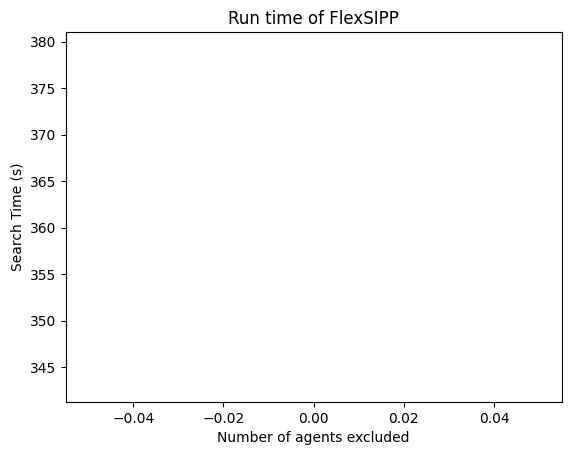

In [12]:
def sum_cols(df1, cols, name):
    df2 = df1.drop(columns=cols)
    df2[name] = df1[cols].sum(axis=1)
    return df2

time_df = pd.DataFrame(time_data)

time_df.to_csv(f"{save_dir}\\time_df-r{repeats}-i{interval}-{date.today()}.csv", index=False)

time_df["Number of agents"] = pd.to_numeric(time_df["label"])

setup_cols = ["track graph creation", "routing graph creation"]
recompute_cols = ["unsafe interval generation", "safe interval generation", "bt and crt generation", "converting routes to blocks"]
search_cols = ["FlexSIPP search time"]

time_df = sum_cols(time_df, setup_cols, "Setup Time")
time_df = sum_cols(time_df, recompute_cols, "Recompute Time")
time_df = sum_cols(time_df, search_cols, "Search Time")

time_mean_std = (
    time_df.groupby(["Number of agents"]).agg({"Search Time":["mean", "std"]})
    .set_axis(["mean", "std"], axis=1)
    .reset_index()
    [["mean", "std"]]
)
fig, ax = plt.subplots()

time_mean_std.plot(ax=ax, yerr="std", errorevery=5, legend=False)
# time_df.loc[time_df["Search Time"] > -1]["Search Time"].plot()
plt.ylabel("Search Time (s)")
plt.xlabel("Number of agents excluded")
plt.title("Run time of FlexSIPP")

plt.savefig(f"{save_dir}\\time_df-{date.today()}.png")

# time_df.plot(ax=ax, x="Number of agents", y="Search Time", kind="scatter", s=1)
time_mean_std

### Search Node Statistics


In [ ]:
nodes_df = pd.DataFrame(complexity_data)

nodes_df.to_csv(f"{save_dir}\\nodes_df-r{repeats}-i{interval}-{date.today()}.csv", index=False)

nodes_df["Agents excluded"] = pd.to_numeric(nodes_df["label"])
nodes_df = nodes_df.groupby("Agents excluded").mean()
nodes_df.plot()
plt.savefig(f"{save_dir}\\nodes_df-{date.today()}.png")

### Output paths found


In [ ]:
# for key, value in experiments[-1].results[3].items():
#     delayed_trains = {i: v for i,v in enumerate(value[0][4]) if float(v[0]) > 0}
#     print(f"{key.replace('r-', '')}\nearliest departure: {int(min(float(value[0][1]), float(value[0][2])) / 60)}\ndepart before: {int(float(value[0][2]) / 60)}\narrive at: {int((float(value[0][1]) + float(value[0][3])) / 60)}\ndelays trains: {delayed_trains}")

### Path statistics


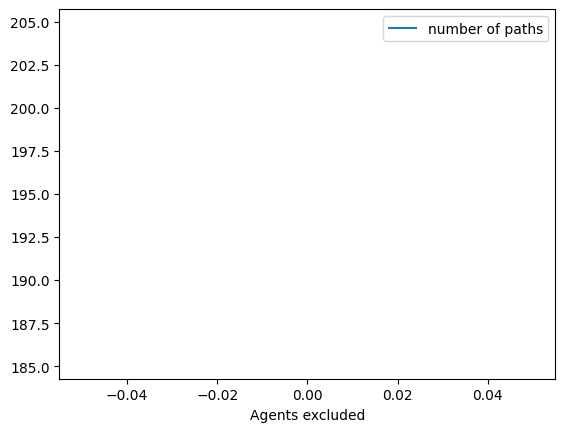

In [13]:
num_paths_df = pd.DataFrame(path_data)

num_paths_df.to_csv(f"{save_dir}\\num_paths_df-r{repeats}-i{interval}-{date.today()}.csv", index=False)
num_paths_df["Agents excluded"] = pd.to_numeric(num_paths_df["label"])
num_paths_df = num_paths_df.groupby("Agents excluded").mean()

num_paths_df.plot()
plt.savefig(f"{save_dir}\\num_paths_df-{date.today()}.png")